In [1]:
import json
import tsd
import numpy as np
import datetime
import utils
import rasterio
import geopandas as gpd
from shapely.geometry import shape
from rasterio.features import geometry_mask

### Load the data

In [2]:
with open('data/landfills_openstreetmap.geojson') as f:
    data = json.load(f)

### Understand the data 

In [39]:
index = 5

In [40]:
print('Number of landfills masks:', len(data['features']))
print('First landfill mask geometry:', data['features'][index]['geometry'])
print('The first landfill mask has :', len(data['features'][index]['geometry']['coordinates']), 'polygons')
print('If there is a second polygon, it might represent a hole in the first polygon.')
print('The coordinates of the first polygon look like:', data['features'][index]['geometry']['coordinates'][0])
print('The first polygon has :', len(data['features'][index]['geometry']['coordinates'][0]), 'points')


Number of landfills masks: 50535
First landfill mask geometry: {'type': 'Polygon', 'coordinates': [[[-81.1778881, 28.4963265], [-81.177872, 28.503101], [-81.1778769, 28.5070797], [-81.1778811, 28.5104125], [-81.2110241, 28.5102522], [-81.2109651, 28.5029407], [-81.2179236, 28.5029211], [-81.2193014, 28.5029172], [-81.2191887, 28.4809561], [-81.2233812, 28.4809443], [-81.2275939, 28.4809325], [-81.2276041, 28.4760993], [-81.2276093, 28.4736375], [-81.2276334, 28.4622439], [-81.2276741, 28.4539204], [-81.2275197, 28.4540242], [-81.2263127, 28.4531092], [-81.2266077, 28.4526706], [-81.2260123, 28.4523687], [-81.2254705, 28.4521848], [-81.2249984, 28.4521093], [-81.2243654, 28.4520763], [-81.2243225, 28.4524395], [-81.2225308, 28.4523168], [-81.2225361, 28.4519678], [-81.2213291, 28.4518923], [-81.2176384, 28.4526753], [-81.2135024, 28.4518829], [-81.209605, 28.4519056], [-81.2094118, 28.4519072], [-81.1779739, 28.4521074], [-81.1779578, 28.466569], [-81.186219, 28.466569], [-81.1862029, 2

### Load a set of sentinel-2 images from OSM polygons of one landfill mask
get_s2_filter_cloudy_img(polygons, start_date, end_date, max_cloud): returns a set of objects refering sentinel-2 images taken between start_date and end_date, with a threshold on the clouds present in the image. 

In [35]:
def get_s2_filter_cloudy_img(aoi, start_date=None, end_date=None, max_cloud_cover=20):
    res = tsd.get_sentinel2.search(aoi, start_date, end_date)
    res2 = []
    for image in res:
      if image.cloud_cover <= max_cloud_cover:
          res2.append(image)    
    return res2

In [41]:
aoi = data['features'][index]['geometry'] # The aoi might be a list of polygons and not only one polygon. 
print('aoi:', aoi)

start = datetime.datetime(2023, 7, 1)
end = datetime.datetime(2023, 12, 31)
max_cloud = 10

s2_images = get_s2_filter_cloudy_img(aoi, start_date = start, end_date = end, max_cloud_cover = max_cloud)
print('Number of images:', len(s2_images))

print('Type of first image:', type(s2_images[0])) #Type of first image: <class 'tsd.s2_metadata_parser.Sentinel2Image'>
for k, v in s2_images[0].items():
    print(k, v)

aoi: {'type': 'Polygon', 'coordinates': [[[-81.1778881, 28.4963265], [-81.177872, 28.503101], [-81.1778769, 28.5070797], [-81.1778811, 28.5104125], [-81.2110241, 28.5102522], [-81.2109651, 28.5029407], [-81.2179236, 28.5029211], [-81.2193014, 28.5029172], [-81.2191887, 28.4809561], [-81.2233812, 28.4809443], [-81.2275939, 28.4809325], [-81.2276041, 28.4760993], [-81.2276093, 28.4736375], [-81.2276334, 28.4622439], [-81.2276741, 28.4539204], [-81.2275197, 28.4540242], [-81.2263127, 28.4531092], [-81.2266077, 28.4526706], [-81.2260123, 28.4523687], [-81.2254705, 28.4521848], [-81.2249984, 28.4521093], [-81.2243654, 28.4520763], [-81.2243225, 28.4524395], [-81.2225308, 28.4523168], [-81.2225361, 28.4519678], [-81.2213291, 28.4518923], [-81.2176384, 28.4526753], [-81.2135024, 28.4518829], [-81.209605, 28.4519056], [-81.2094118, 28.4519072], [-81.1779739, 28.4521074], [-81.1779578, 28.466569], [-81.186219, 28.466569], [-81.1862029, 28.4957513], [-81.1778934, 28.4957843], [-81.1778881, 28.49

### Select one S2 image, crop it to obtain a squared image around the polygons of interest, augment the contrast and plot it. 

In [50]:
#def get_bb_from_polygon(aoi):
#    return tsd.utils.bbox_from_polygon(aoi)

def polygon_area(pts):
    """
    Calculate the area of a polygon using the shoelace formula.

    Args:
        pts (list): list of 2D points represented as 2-tuples or lists of length 2

    Returns:
        area (float): the area of the polygon
    """
    n = len(pts)
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += pts[i][0] * pts[j][1]
        area -= pts[j][0] * pts[i][1]
    area = abs(area) / 2.0
    return area

def square_bounding_box_from_polygon(pts, occupancy=0.3): # Generates squared bounding box from polygon given in input as list of points, 
    #ensuring the polygon occupies a specified percentage of the image.

    poly_area = polygon_area(pts)

    # Calculate the required side length of the square so that the polygon area is approximately 60% of the square area
    square_area = poly_area / occupancy
    side_length = square_area ** 0.5

    # Calculate the bounding box to find the center of the polygon
    x_min = min(pt[0] for pt in pts)
    y_min = min(pt[1] for pt in pts)
    x_max = max(pt[0] for pt in pts)
    y_max = max(pt[1] for pt in pts)

    # Center the new square bounding box around the original polygon's bounding box
    x_center = x_min + (x_max - x_min) / 2
    y_center = y_min + (y_max - y_min) / 2

    # Calculate new top-left corner of the square bounding box
    new_x_min = x_center - side_length / 2
    new_y_min = y_center - side_length / 2

    # return coordinates of the top-left corner, width and height of the bounding box
    return new_x_min, new_y_min, side_length

def utm_bbx(aoi, epsg=None, r=None, offset=(0, 0)):
    #Compute UTM squared bounding box of a longitude, latitude AOI.
    if epsg is None:  # compute the EPSG code of the AOI centroid
        lon, lat = np.mean(aoi['coordinates'][0][:-1], axis=0)
        epsg = tsd.utils.compute_epsg(lon, lat)

    # convert all polygon vertices coordinates from (lon, lat) to utm
    lons, lats = np.asarray(aoi['coordinates'][0]).T
    xs, ys = tsd.utils.pyproj_transform(lons, lats, 4326, epsg)
    c = list(zip(xs, ys))

    # utm bounding box
    x, y, w = square_bounding_box_from_polygon(c)  # minx, miny, width, height
    ulx, uly, lrx, lry = x, y + w, x + w, y

    # FIXME Rounding when epsg:4326
    if r is not None and epsg != 4326:  # round to multiples of the given resolution
        ox, oy = offset
        ulx = ox + r * np.round((ulx - ox) / r)
        uly = oy + r * np.round((uly - oy) / r)
        lrx = ox + r * np.round((lrx - ox) / r)
        lry = oy + r * np.round((lry - oy) / r)

    return ulx, uly, lrx, lry, epsg # bounding box upper left (ul) and lower right (lr) x, y coordinates

def get_squared_img_crop_from_aoi(output_path, aoi, catalog_entry, band):
    metadata = catalog_entry

    if not metadata.urls['aws']:
        metadata.build_s3_links()

    inpath = metadata.urls['aws'][band]

    utm_zone = metadata.get("utm_zone")
    lat_band = metadata.get("lat_band")

    epsg = tsd.utils.utm_to_epsg_code(utm_zone, lat_band) if utm_zone else None

    ulx, uly, lrx, lry, epsg = utm_bbx(aoi, epsg=epsg, r=60)
    tsd.utils.rasterio_geo_crop(output_path, inpath, ulx, uly, lrx, lry, epsg=epsg) 

def simple_equalization_8bit(im, percentiles=5):
    low = np.percentile(im, percentiles)
    high = np.percentile(im, 100-percentiles)

    im = np.clip(im, low, high)
    im = (im - low) / (high - low)
    im = np.uint8(im * 255)

    return im

def get_squared_crop_s2(basefilename, aoi, sentinel2_images, percentiles=5):
    bands = ['B04', 'B03', 'B02']    # SENTINEL2 R,G,B BANDS
    for b in bands:
        get_squared_img_crop_from_aoi('toy_images/{}_{}.tif'.format(basefilename, b), aoi, sentinel2_images, b)

    # read, equalize, and stack all the channels
    out = []
    for b in bands:
        im = utils.readGTIFF('toy_images/{}_{}.tif'.format(basefilename, b))
        im = simple_equalization_8bit(im, percentiles)
        out.append(im)

    # The transposition is necessary because the indexing
    # convention for color images is (height, width, channels)
    im = np.squeeze(out,axis=(3)).transpose(1,2,0)
    utils.writeGTIFF(im, 'toy_images/{}_RGB.tif'.format(basefilename), 'toy_images/' + basefilename + '_B04.tif')
    return im

In [51]:
img = get_squared_crop_s2('first_landfill', aoi, s2_images[0], percentiles=5)

img shape: (918, 918, 3)
img type: <class 'numpy.ndarray'>


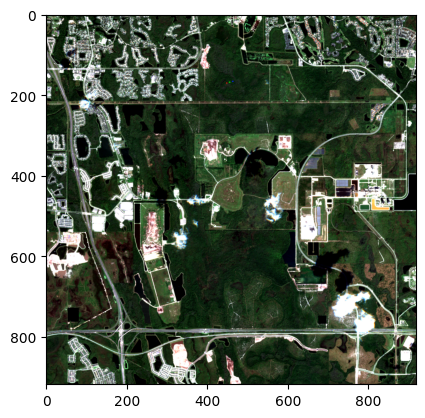

In [52]:
print('img shape:', img.shape)
print('img type:', type(img))

import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()

### Create a mask image from the OSM polygons and plot it top of the S2 image selected

In [53]:
my_path = 'toy_images/first_landfill_RGB.tif'

with rasterio.open(my_path) as src:
    epsg = src.crs
    print(f"Raster CRS of the saved RGB image: {epsg}")

print("By default, the polygons are in WGS84 (EPSG:4326) which is a standard for geoJSON format.")

Raster CRS of the saved RGB image: EPSG:32617
By default, the polygons are in WGS84 (EPSG:4326) which is a standard for geoJSON format.


### Draw a mask from the polygon and plot it on top of the image

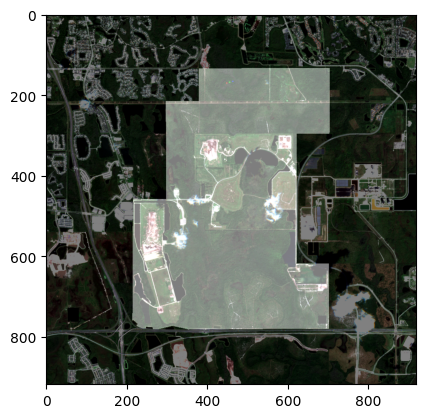

In [55]:
# Polygon in GeoJSON format (in longitude, latitude)
geojson_polygon = data['features'][index]['geometry']  

# Convert GeoJSON to Shapely Geometry
polygon = shape(geojson_polygon)

# Create a GeoDataFrame with the polygon
gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs="EPSG:4326")  # Set initial CRS to WGS 84

# Reproject the GeoDataFrame to match the raster's CRS (EPSG:32633)
gdf = gdf.to_crs(epsg)

# Now proceed with rasterio to read the raster and create the mask
with rasterio.open(my_path) as src:
    # First 3 bands (RGB)
    img = src.read([1, 2, 3])
    # Adjust image data for display
    img = np.moveaxis(img, 0, -1)  # Rearrange dimensions for matplotlib (Height x Width x Channels)
    
    # Create a mask using the reprojected polygon
    mask = geometry_mask([gdf.geometry[0]], invert=True, transform=src.transform, all_touched=True, out_shape=(src.height, src.width))
    # save mask_file
    mask_file = 'toy_images/first_landfill_mask.tif'
    # Display the original image
    plt.imshow(img)
    
    # Overlay the mask with some transparency
    plt.imshow(mask, cmap='gray', alpha=0.5)
    
    plt.show()

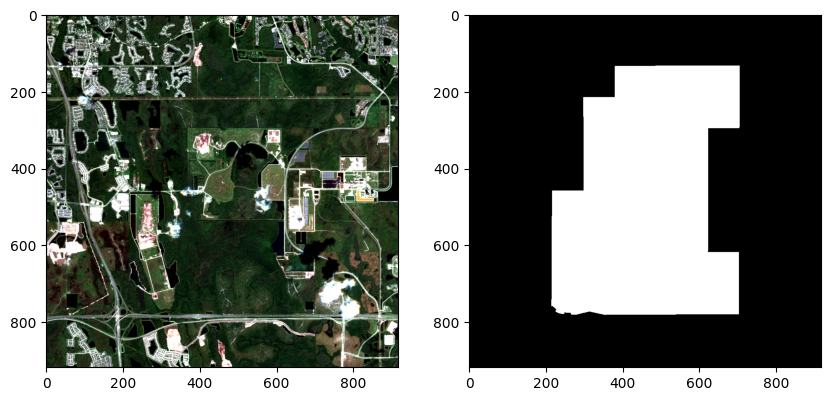

In [56]:
#plot image and mask side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[1].imshow(mask, cmap='gray')
plt.show()

In [18]:
# print the number of poylgons in the original image 
print('The number of polygons in the original image:', len(data['features'][index]['geometry']['coordinates']))

The number of polygons in the original image: 2
